# Demand Forecasting — Modeling & Evaluation

This notebook focuses on time-aware data splitting, baseline modeling,
and evaluation of forecasting performance.


In [ ]:
import pandas as pd

train_df = pd.read_csv("../data/raw/train.csv")

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['store','item','date']).reset_index(drop=True)

# calendar features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.isocalendar().week.astype(int)
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)

# lag & rolling
for lag in [7,14,28]:
    df[f'lag_{lag}'] = df.groupby(['store','item'])['sales'].shift(lag)

for w in [7,14,28]:
    df[f'rolling_mean_{w}'] = (
        df.groupby(['store','item'])['sales']
        .shift(1)
        .rolling(w)
        .mean()
    )

df = df.dropna().reset_index(drop=True)


In [4]:
BASE_FEATURES = [
    'store','item','year','month','week','day',
    'dayofweek','is_weekend'
]

LAG_FEATURES = [
    'lag_7','lag_14','lag_28'
]

ROLLING_FEATURES = [
    'rolling_mean_7','rolling_mean_14','rolling_mean_28'
]

FEATURES = BASE_FEATURES + LAG_FEATURES + ROLLING_FEATURES
TARGET = 'sales'


Time-based Split

In [5]:
split_date = "2017-01-01"

train_df = df[df['date'] < split_date]
valid_df = df[df['date'] >= split_date]

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_valid = valid_df[FEATURES]
y_valid = valid_df[TARGET]

BASELINE MODEL

Install & Import

In [9]:
pip install lightgbm


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 8.5 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 8.5 MB/s  0:00:00


In [10]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

Dataset ke LightGBM Format

In [11]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)


Parameter Baseline

In [14]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}

Training

In [16]:
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1487
[LightGBM] [Info] Number of data points in the train set: 716500, number of used features: 14
[LightGBM] [Info] Start training from score 51.022620
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 8.08897	valid_1's rmse: 9.00107
[100]	training's rmse: 7.51144	valid_1's rmse: 8.18662
[150]	training's rmse: 7.42671	valid_1's rmse: 8.06526
[200]	training's rmse: 7.38627	valid_1's rmse: 8.01615
[250]	training's rmse: 7.35736	valid_1's rmse: 7.98488
[300]	training's rmse: 7.33563	valid_1's rmse: 7.96343
[350]	training's rmse: 7.31855	valid_1's rmse: 7.94834
[400]	training's rmse: 7.30462	valid_1's rmse: 7.93859
[450]	training's rmse: 7.29185	valid_1's rmse: 7.93065
[500]	training's rmse: 7.2803	valid_1's rmse: 7.92328
Did not meet early stopping. Best iteration is:

In [ ]:
Evaluasi

In [18]:
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)
rmse, mae

(np.float64(7.923279518865139), 6.101865851416897)

Baseline LightGBM model achieved RMSE of 7.9 and MAE of 6.1 on a one-year holdout validation set, indicating strong ability to capture seasonal and historical demand patterns.

In [ ]:
Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

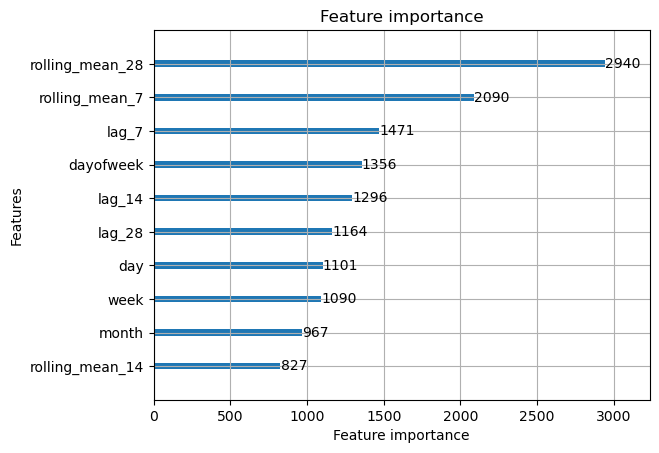

In [19]:
lgb.plot_importance(model, max_num_features=10)

Feature importance analysis shows that historical rolling averages and short-term lags dominate the model, indicating demand is primarily driven by recent sales behavior rather than static calendar features.